In [1]:
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from pandas_highcharts.core import serialize
from pandas_highcharts.display import display_charts

import matplotlib
import matplotlib.pyplot as plt

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

In [2]:
%%capture
%run -t monitor_daily.ipynb

In [3]:
%store -r MONITOR_TARGET
%store -r stock_df_dict

,SYMBOL,DATE,NOW,BUY,BUYDIFF,SELL,SELLDIFF
0,399300,2019-06-04,3598.47,4120.61,+14.51%,3583.96,-0.40%
1,000905,2019-06-04,4795.41,5810.18,+21.16%,4795.41,-0.00%
2,399006,2019-06-04,1456.27,1777.26,+22.04%,1443.75,-0.86%


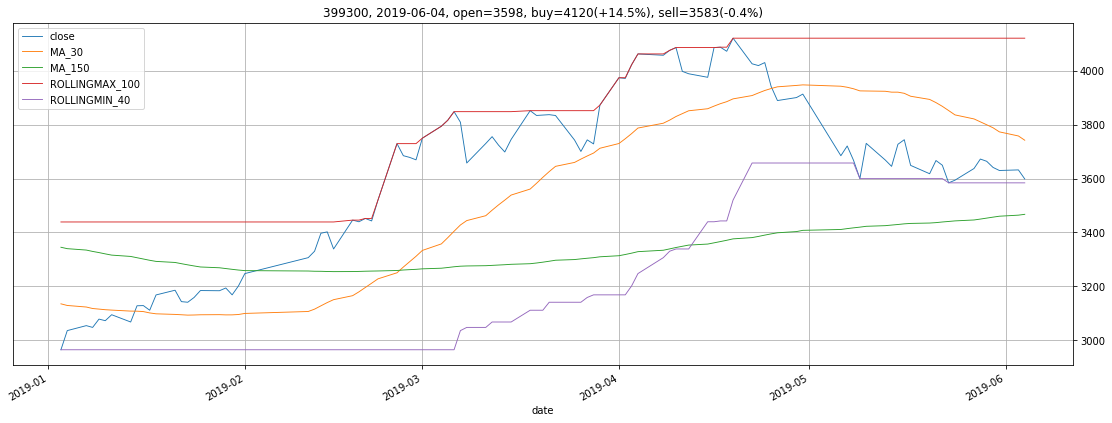

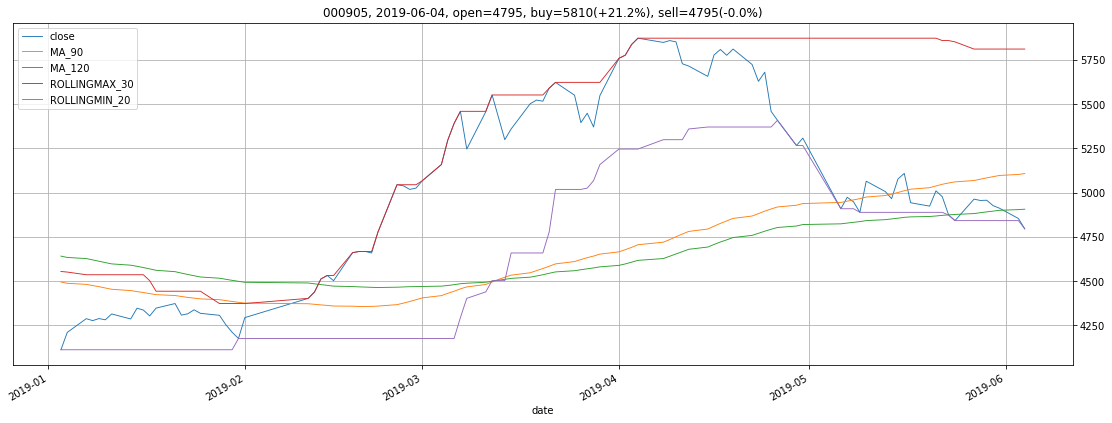

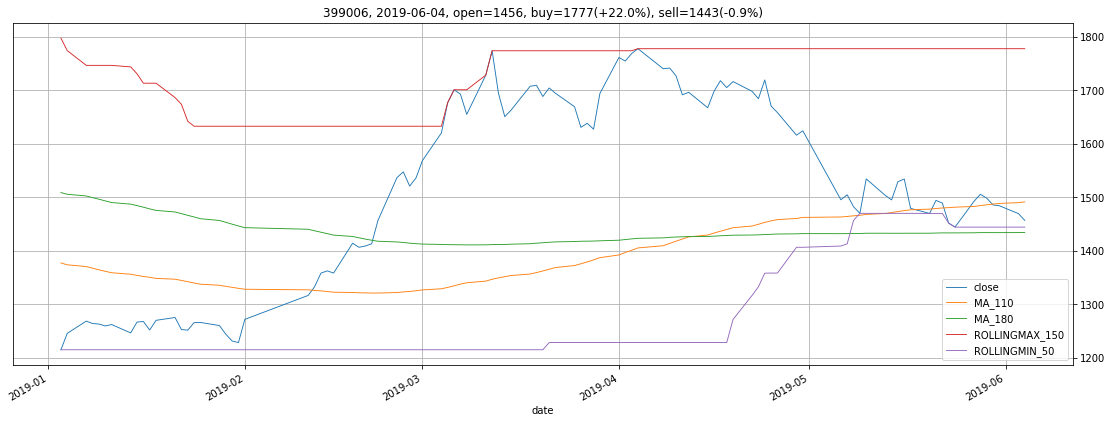

In [4]:
monitor_df = pd.DataFrame(columns=['SYMBOL', 'DATE', 'NOW', 'BUY', 'BUYDIFF', 'SELL', 'SELLDIFF'])

for symbol in MONITOR_TARGET:
    df = stock_df_dict[symbol].iloc[-100:].copy()    
    df.reset_index(drop=False, inplace=True)
    # df = df.astype(dtype={'date': 'datetime64[ns]'})
    df['date'] = df['date'].apply(lambda x: x.to_timestamp().to_datetime64())
    df.set_index('date', inplace=True)

    today_market = df.iloc[-1]
    now_point = today_market.close
    for col in df.columns:
        if 'ROLLINGMAX' in col:
            buy_point = today_market[col]
            buy_diff = (buy_point - now_point) / now_point * 100
        elif 'ROLLINGMIN' in col:
            sell_point = today_market[col]
            sell_diff = (now_point - sell_point) / now_point * 100
    
    monitor_df = monitor_df.append({
        'SYMBOL': symbol, 
        'DATE': today_market.name.date(), 
        'NOW': now_point, 
        'BUY': buy_point, 
        'BUYDIFF': '+%.2f%%' % buy_diff, 
        'SELL': sell_point, 
        'SELLDIFF': '-%.2f%%' % sell_diff,
    }, ignore_index=True)
    
    title = '%s, %s, open=%d, buy=%d(+%.1f%%), sell=%d(-%.1f%%)' % \
        (symbol, today_market.name.date(), now_point, buy_point, buy_diff, sell_point, sell_diff)
#     display_charts(df, chart_type='stock', kind='line', title=title, figsize=(1000, 600))
    ax = df.plot(kind='line', title=title, linewidth=0.9, grid=True, figsize=(19, 7))
    ax.yaxis.tick_right()
    
monitor_df